# Imports and Setup

In [1]:
#!pip install numpy tensorflow matplotlib scikit-image

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.16.1


# Load and Preprocess Data

In [4]:
# Load the MNIST dataset.
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values to [0, 1] and convert to float32.
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape images to include a channel dimension (height, width, channels).
if x_train.ndim == 3:
    x_train = np.expand_dims(x_train, axis=-1)
if x_test.ndim == 3:
    x_test = np.expand_dims(x_test, axis=-1)

print(f"x_train shape after loading and preprocessing: {x_train.shape}")
print(f"x_test shape after loading and preprocessing: {x_test.shape}")

x_train shape after loading and preprocessing: (60000, 28, 28, 1)
x_test shape after loading and preprocessing: (10000, 28, 28, 1)


# Add Noise to the Data

In [5]:
# Define the noise factor.
noise_factor = 0.5

# Add random Gaussian noise to the images.
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip pixel values to the valid range [0, 1].
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

print("Noise added to training and test images.")
print(f"x_train_noisy shape: {x_train_noisy.shape}")
print(f"x_test_noisy shape: {x_test_noisy.shape}")

Noise added to training and test images.
x_train_noisy shape: (60000, 28, 28, 1)
x_test_noisy shape: (10000, 28, 28, 1)


# Define and Compile the U-Net Denoising Autoencoder Model

In [6]:
def conv_block(input_tensor, num_filters):
    """Convolutional block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU"""
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def build_lite_unet_denoising_autoencoder(input_shape=(28, 28, 1)):
    """Builds a U-Net model for faster CPU training."""
    inputs = Input(shape=input_shape)

    # Encoder (Contracting Path)
    # Block 1
    c1 = conv_block(inputs, 16) 
    p1 = MaxPooling2D((2, 2))(c1)
    # Block 2
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    # Bottleneck
    bn = conv_block(p2, 64)

    # Decoder (Expansive Path)
    # Block 1
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(bn)
    u1 = Concatenate()([u1, c2])
    c3 = conv_block(u1, 32)
    # Block 2
    u2 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = Concatenate()([u2, c1])
    c4 = conv_block(u2, 16) 

    # Output Layer
    # Conv2D with 1 filter and sigmoid activation for grayscale output [0, 1]
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the U-Net autoencoder model
autoencoder = build_lite_unet_denoising_autoencoder()

# Define and Use Callbacks for Training

In [7]:
# EarlyStopping: Stops training if validation loss doesn't improve for a set number of epochs.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restores model weights from the epoch with the best val_loss
    verbose=1
)

# ReduceLROnPlateau: Reduces learning rate when validation loss plateaus.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001, # Lower bound on the learning rate
    verbose=1
)

# Train the model
print("Starting model training (U-Net)...")
history = autoencoder.fit(
    x_train_noisy,
    x_train,
    epochs=10,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, reduce_lr]
)
print("Model training finished.")

Starting model training (U-Net)...
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 142s 528ms/step - loss: 0.0819 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 122s 518ms/step - loss: 0.0140 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 122s 519ms/step - loss: 0.0109 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 122s 521ms/step - loss: 0.0099 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 122s 518ms/step - loss: 0.0095 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 122s 518ms/step - loss: 0.0092 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 122s 517ms/step - loss: 0.0090 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 122s 519ms/step - loss: 0.0088 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 122s 518ms/st

# Evaluate the Model (PSNR and SSIM)

In [8]:
print("Denoising test images (U-Net)...")
denoised_images = autoencoder.predict(x_test_noisy)
print("Test images denoised.")

# Compute PSNR and SSIM
print("Computing PSNR and SSIM (U-Net)...")
psnr_values = [psnr(x_test[i].squeeze(), denoised_images[i].squeeze(), data_range=1.0) for i in range(len(x_test))]
ssim_values = [ssim(x_test[i].squeeze(), denoised_images[i].squeeze(), data_range=1.0, channel_axis=None, win_size=7) for i in range(len(x_test))]

print(f"Average PSNR (U-Net): {np.mean(psnr_values):.2f} dB")
print(f"Average SSIM (U-Net): {np.mean(ssim_values):.4f}")

Denoising test images (U-Net)...
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step
Test images denoised.
Computing PSNR and SSIM (U-Net)...
Average PSNR (U-Net): 20.96 dB
Average SSIM (U-Net): 0.8371


# Plot Original, Noisy, and Denoised Images

In [9]:
def plot_images(original, noisy, denoised, model_name="Denoised", n=10):
    """Plots n examples of original, noisy, and denoised images."""
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display Original Image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap="gray")
        if i == 0:
            ax.set_title("Original")
        plt.axis("off")

        # Display Noisy Image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy[i].squeeze(), cmap="gray")
        if i == 0:
            ax.set_title("Noisy")
        plt.axis("off")

        # Display Denoised Image
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(denoised[i].squeeze(), cmap="gray")
        if i == 0:
            ax.set_title(model_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Plotting function defined.")

Plotting function defined.


# Display Example Results

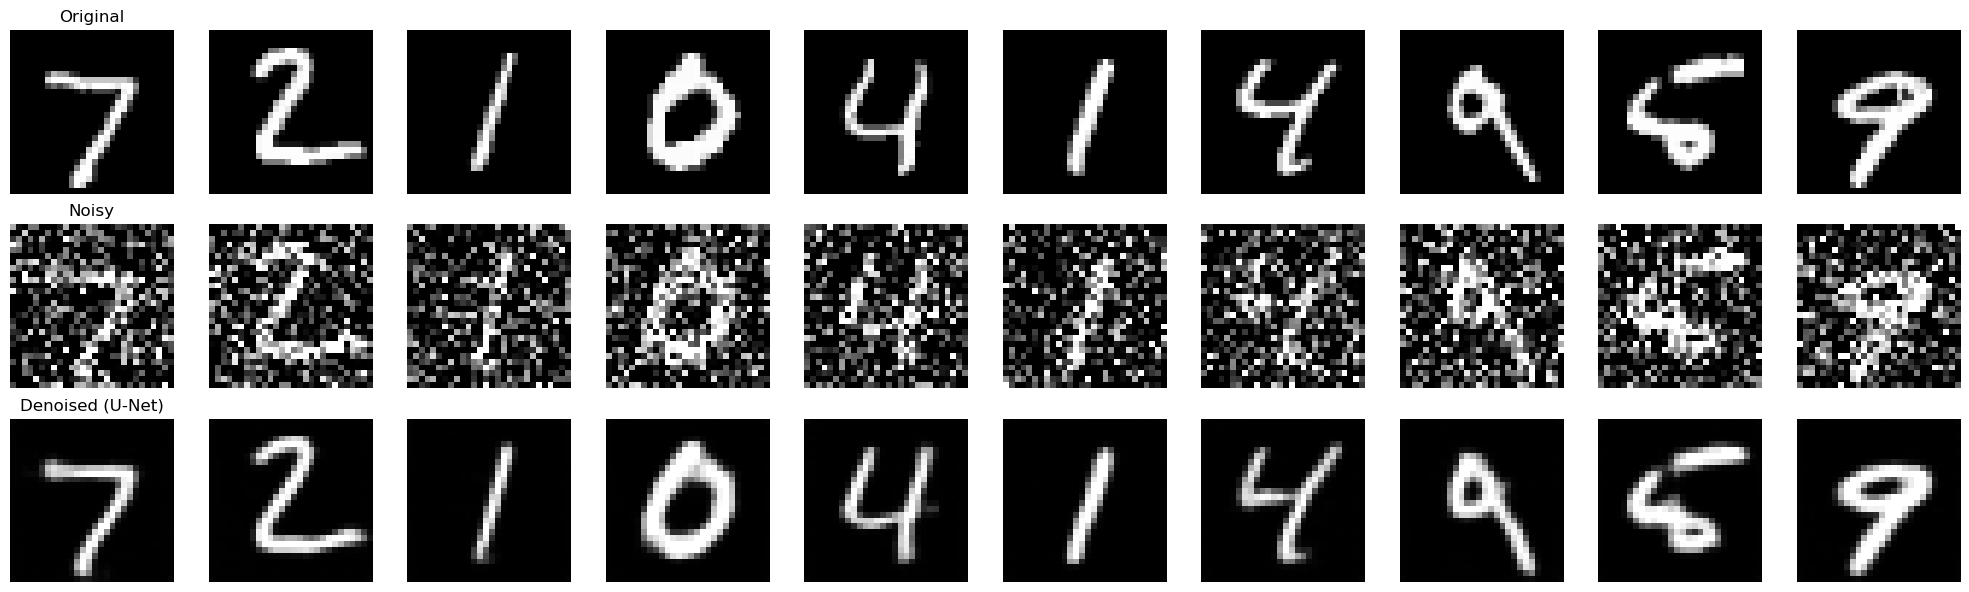

In [10]:
# Display 10 examples from the test set
plot_images(x_test, x_test_noisy, denoised_images, model_name="Denoised (U-Net)", n=10)

# Thank You !)